# General overview on Recommendation systems for movies

There are basically three types of recommender systems:

* **Demographic Filtering**: offer generalized recommendations to every user, based on movie popularity and/or genre. The System recommends the same movies to users with similar demographic features. Since each user is different , this approach is considered to be too simple. The basic idea behind this system is that movies that are more popular and critically acclaimed will have a higher probability of being liked by the average audience.

* **Content Based Filtering**: suggest similar items based on a particular item. This system uses item metadata, such as genre, director, description, actors, etc. for movies, to make these recommendations. The general idea behind these recommender systems is that if a person liked a particular item, he or she will also like an item that is similar to it.

* **Collaborative Filtering**: this system matches persons with similar interests and provides recommendations based on this matching. Collaborative filters do not require item metadata like its content-based counterparts.

# Proposal

A possible way to recommend movies could be a mix of **Content Based Filtering** and **Collaborative Filtering**. 

To build a simple **hybrid** recommender that brings together techniques from the content based and collaborative filter based engines.



- **Input**: Movies that a particular user likes
- **Output**: Similar movies sorted on the basis of expected ratings by that particular user.

Below I let some code for general recommendation system based on overall data (Content Based), some personalized recommendation system based on user ratings (Collaborative Filtering) and mix of both a hybrid model.

Next steps:
- Think about the optimal model (How it should take input data, what it should output, do we need to retrain our model online??

#### Content Based Filtering
*Based only on the movie description* 

In [4]:
import warnings
import numpy as np
import time
import pandas as pd
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 500

In [5]:
# Read meta data about movies
md = pd.read_csv('../data/input/movies_metadata.csv')
movies = pd.read_csv('../data/input/movies.csv')
directors = pd.read_csv('../data/input/directors.csv')
ids_to_use = np.loadtxt('movieIds_TO_USE.txt')

In [6]:
md.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


#### Generating TF-IDF features

In [7]:
# Apply some preprocessing on meta data about movies

md['genres'] = md['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
md['year'] = pd.to_datetime(md['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [ ]:
# Filter only for movie mapping that has tmdbId

links_small = pd.read_csv('../data/input/links0.csv')
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

In [9]:
movies.columns

Index(['movieId', 'imdbId', 'tmdbId', 'title', 'year', 'num_ratings',
       'avg_rating', 'isAdult', 'runtimeMinutes', 'directors', 'directorId',
       'no_genres', 'action', 'adventure', 'animation', 'children', 'comedy',
       'crime', 'documentary', 'drama', 'fantasy', 'film-noir', 'horror',
       'imax', 'musical', 'mystery', 'romance', 'sci-fi', 'thriller', 'war',
       'western', 'genres'],
      dtype='object')

In [10]:
# Need to drop these wrong entries
#md.iloc[[19730, 29503, 35587],]
md = md.drop([19730, 29503, 35587])

# Take meta data about movies with mapping
md['id'] = md['id'].astype('int')
#smd = md[md['id'].isin(links_small)]
#smd.shape

# Add directors and movielens id
movies = movies.merge(directors[['directorId', 'name']], on = 'directorId')
movies = movies.rename({'name':'director_name', 'imdbId':'imdb_id'}, axis=1)
smd = md.merge(movies[['director_name', 'imdb_id', 'movieId']], on='imdb_id')

In [11]:
# FILTER BY MOVIES WITH AT LEAST 100 REVIEWS

smd = smd[smd['movieId'].isin(ids_to_use)]

In [12]:
# Preprocess tagline and description

smd['tagline'] = smd['tagline'].fillna('')
smd['description'] = smd['overview'] + smd['tagline'] + smd['director_name']
smd['description'] = smd['description'].fillna('')

In [15]:
len(smd['movieId'])

9643

In [24]:
# Drop duplicates

smd = smd.loc[smd['movieId'].drop_duplicates().index].sort_values('movieId')

In [28]:
# Apply and create TF-IDF features

start_time = time.time()

tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(smd['description'])
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

print(f'Time to train was: {time.time() - start_time} seconds' )

Time to train was: 2.74613881111145 seconds


#### Export similarity matrix based on description, tagline and directors

In [29]:
tfidf_matrix

<9643x296269 sparse matrix of type '<class 'numpy.float64'>'
	with 604840 stored elements in Compressed Sparse Row format>

In [30]:
cosine_sim.shape

(9643, 9643)

In [31]:
cosine_sim[0:4,0:4]

array([[1.        , 0.00639703, 0.00285656, 0.        ],
       [0.00639703, 1.        , 0.01473762, 0.        ],
       [0.00285656, 0.01473762, 1.        , 0.        ],
       [0.        , 0.        , 0.        , 1.        ]])

In [32]:
np.savetxt('content_based_matrix.txt', cosine_sim, fmt='%1.4f')

#### Playground

In [33]:
smd = smd.reset_index(drop=True)

In [34]:
a = pd.DataFrame({"index": smd.index, "movieId": smd['movieId'], "title":smd['title']})
a

,index,movieId,title
0,0,1,Toy Story
1,1,2,Jumanji
2,2,3,Grumpier Old Men
3,3,4,Waiting to Exhale
4,4,5,Father of the Bride Part II
...,...,...,...
9638,9638,175585,Shot Caller
9639,9639,175655,Girls Trip
9640,9640,175659,Detroit
9641,9641,175667,Columbus


In [35]:
pd.DataFrame({"index": smd.index, "movieId": smd['movieId'], "title":smd['title']}).to_csv('content_based_index.txt', index=False)

In [15]:
pd.Series(smd.index, index=smd['title'])

title
Toy Story                         0
Jumanji                           1
Grumpier Old Men                  2
Waiting to Exhale                 3
Father of the Bride Part II       4
                               ... 
Wind River                     9644
Shot Caller                    9645
Girls Trip                     9646
Detroit                        9647
Columbus                       9648
Length: 9649, dtype: int64

In [49]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [50]:
# Create simple get function

def get_recommendations(title:str, recommendations:int):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices].head(recommendations)

In [52]:
# Get 5 recommendation for Toy Story movie

get_recommendations(title = 'American History X', recommendations = 5)

13140                         Obsessed
31617    The Education of Sonny Carson
4610                         Zoolander
26321                         Baseline
11993                     Blind Dating
Name: title, dtype: object

In [56]:
# If we want to add to the description the rating part we can apply the following 

# we can play with these parameters
vote_counts = md[md['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = md[md['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
m = vote_counts.quantile(0.95)

def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

def get_recommendations_2(title:str, recommendations:int):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    
    # we can play with these parameters
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    
    
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified.head(recommendations)

In [57]:
get_recommendations_2(title = 'Toy Story', recommendations = 5)

,title,vote_count,vote_average,year,wr
7336,Toy Story 3,4710,7,2010,6.851922
2352,Toy Story 2,3914,7,1999,6.824813
6057,Match Point,1134,7,2005,6.514212
941,Manhattan,600,7,1979,6.263332
9198,Hunt for the Wilderpeople,453,7,2016,6.141246


In [ ]:
## Irene's code

In [17]:
pwd

'/Users/arseniykolmagorov/Desktop/Universitat/Q1/CIÈNCIA DE DADES ÀGIL/agile-project/GetMeAMovie/Data & ML'

In [319]:
import pandas as pd
import numpy as np

all_ratings = pd.read_csv('ratings.csv')
all_ratings.drop('rating_date', axis=1, inplace=True) 
print('hey')
# Exclude movies not rated by 100 users
#keep = all_ratings.movieId.value_counts()[all_ratings.movieId.value_counts() > 100].index.values
all_ratings = all_ratings.loc[all_ratings.movieId.isin(smd['movieId']),:]
print('hey')
def assign_to_set(df):
    sampled_ids = np.random.choice(df.index,
                                   size=np.int64(np.ceil(df.index.size * 0.5)),
                                   replace=False)
    df.loc[sampled_ids, 'for_testing'] = True
    return df


hey
hey


In [320]:
from tqdm import tqdm
all_ratings.loc[:,'for_testing'] = False
all_ratings = all_ratings.groupby('userId', group_keys=False).apply(assign_to_set) 
print('hey')
training_ratings = all_ratings[all_ratings.for_testing == False]
test_ratings = all_ratings[all_ratings.for_testing == True]
print('hey')
def predict(user, train_rates, test_rates, similarity, all_movies):
    #user_rates = all_rates[all_rates.userId == user, :]
    train_rates = train_rates[train_rates.userId == user]
    test_rates = test_rates[test_rates.userId == user]
    
    
    rated_movies = train_rates.movieId.values
    ratings = train_rates.rating.values
    
    to_rate_movies = test_rates.movieId.values
    to_rate_y = test_rates.rating.values
    
    reduced_sim = similarity[all_movies.isin(rated_movies), :][:, all_movies.isin(to_rate_movies).values]
    
    prediction = np.dot(ratings, reduced_sim)/np.sum(reduced_sim, axis=0)
    
    error = prediction - to_rate_y
    
    return error

hey
hey


In [222]:
def get_even(train, test):
    if train.shape[0]>test.shape[0]:
        print('train has more rows than test')
        while train.shape[0]>test.shape[0]:
            train = train.drop(train.index[[0]])
        return train, test
    else:
        print('test has more rows than train')
        while train.shape[0]<test.shape[0]:
            test = test.drop(test.index[[0]])
        return train, test

In [263]:
all_movies[810]

976

In [407]:
len(np.unique(smd['movieId']))

9643

In [317]:
all_movies = smd['movieId']
similarity = cosine_sim

In [318]:
train_rates = training_ratings[training_ratings.userId == user]
test_rates = test_ratings[test_ratings.userId == user]

#train_rates, test_rates = get_even(train_rates, test_rates)

rated_movies = train_rates.movieId.values
ratings = train_rates.rating.values

to_rate_movies = test_rates.movieId.values
to_rate_y = test_rates.rating.values

reduced_sim = similarity[all_movies.isin(rated_movies), :][:, all_movies.isin(to_rate_movies).values]

prediction = np.dot(ratings, reduced_sim.T)/np.sum(reduced_sim, axis=0)

error = prediction - to_rate_y

ValueError: shapes (319,) and (320,319) not aligned: 319 (dim 0) != 320 (dim 0)

In [177]:
test_rates.shape

(320, 4)

In [322]:
all_error = []
user_rmse = []
n_rated = []
print('hey')
for user in tqdm(training_ratings.userId.unique()):
    error = predict(user, training_ratings, test_ratings, cosine_sim, smd['movieId'])
    all_error.append(error.tolist())
    user_rmse.append(np.sqrt(np.mean(np.power(np.array(error), 2))))
    n_rated.append(np.sum(all_ratings.userId == user))
    
rmse = np.sqrt(np.nanmean(np.power(list(itertools.chain.from_iterable(all_error)), 2)))

  0%|          | 0/162538 [00:00<?, ?it/s]

hey


100%|██████████| 162538/162538 [2:39:24<00:00, 16.99it/s]  


In [413]:
len(all_error[3])

110

In [416]:
len(n_rated)

162538

In [323]:
rmse

0.9506228279092737

In [383]:
u_error = user_rmse.copy()
copy_n_rated = n_rated.copy()

In [384]:
for i in np.argwhere(np.isnan(user_rmse)):
    u_error[i[0]] = 99999999
    copy_n_rated[i[0]] = 99999999

In [394]:
while True:
    try:
        u_error.remove(99999999)
    except:
        print('u_error is done')
        break

while True:
    try:
        copy_n_rated.remove(99999999)
    except:
        print('copy_n_rated is done')
        break

u_error is done
copy_n_rated is done


In [369]:
a[[i for i in range(162538) if i not in np.argwhere(np.isnan(user_rmse))]]

KeyboardInterrupt: 

In [342]:
len(np.argwhere(np.isnan(user_rmse)))

12065

In [343]:
len(np.argwhere(np.isnan(user_rmse)))/len(user_rmse)

0.07422879572776828

In [397]:
print(np.corrcoef(u_error, copy_n_rated))

[[ 1.         -0.09258274]
 [-0.09258274  1.        ]]


In [405]:
np.mean(u_error)

0.956651204286724

In [406]:
np.var(u_error)

0.08679173210086172

In [ ]:
plt.scatter(x, y, s=s)

In [424]:
d = {'predicted' : user_rmse,
     'rated' : n_rated}

df = pd.DataFrame(d)

In [428]:
df[df['rated']<100]['predicted']

0         0.615121
5         1.012113
6         0.600873
9         0.911509
10        0.993816
            ...   
162527    1.218785
162531    0.879869
162532    0.693667
162535    0.720349
162536    1.154124
Name: predicted, Length: 99679, dtype: float64

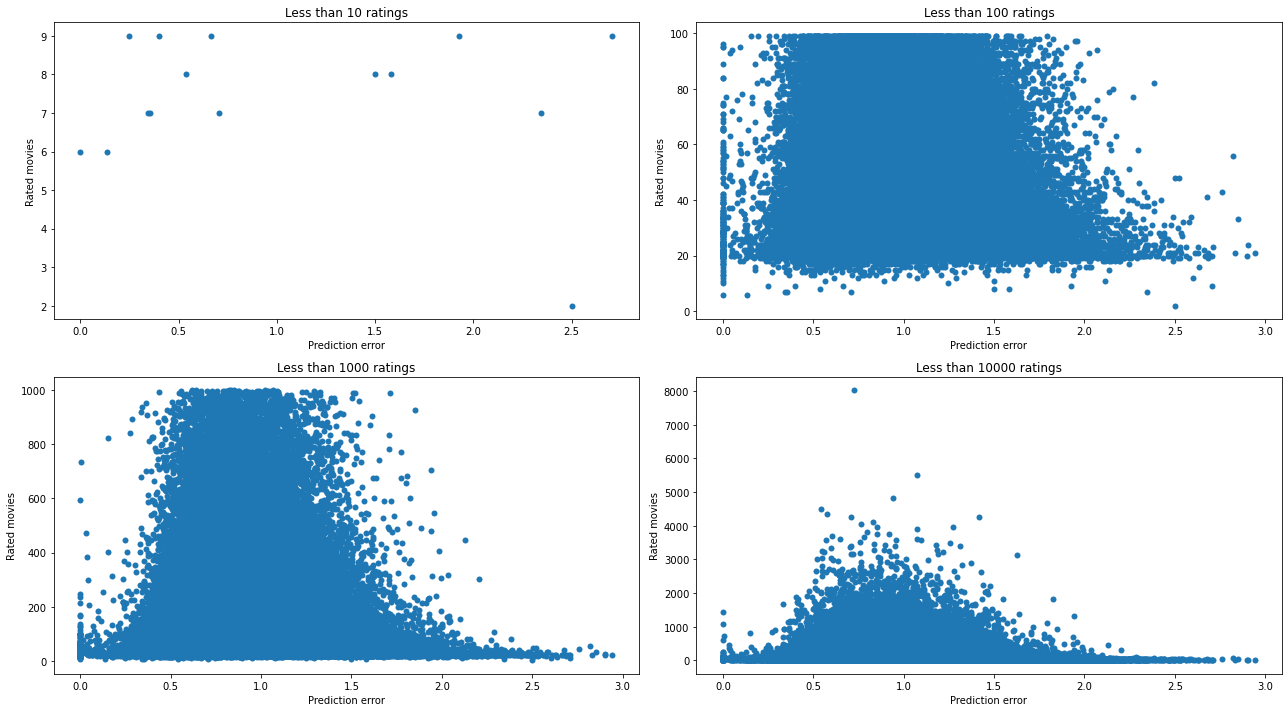

In [453]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

#figure(figsize = (15, 10), dpi = 80)

#plt.scatter(df[df['rated']<10]['predicted'], df[df['rated']<10]['rated'])
    
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))  # define the figure and subplots
colors = ['tab:blue', 'tab:orange', 'tab:green']  # list of colors for each subplot, otherwise all subplots will be one color
rates = [10, 100, 1000, 10000]

k = 0
for i in range(2):
    for j in range(2):
        axes[i, j].scatter(df[df['rated']<rates[k]]['predicted'], df[df['rated']<rates[k]]['rated'], linewidths=0.001)
        #axes[i, j].title('Less than {} ratings'.format(rates[k]))
        plt.setp(axes[i, j], xlabel='Prediction error')
        plt.setp(axes[i, j], ylabel='Rated movies')
        plt.setp(axes[i, j], title='Less than {} ratings'.format(rates[k]))
        k+=1
    
fig.tight_layout()
plt.show()

In [ ]:
d = {'predicted' : user_rmse,
     'rated' : n_rated}

df = pd.DataFrame(d)

#df.plot(style=['o','rx'], figsize=(15, 10))
df['predicted'].plot(style=['o'], figsize=(15, 10))

#### Direct correlation

In [458]:
df.corr()

,predicted,rated
predicted,1.000000,-0.092583
rated,-0.092583,1.000000


#### Less than 10 reviews correlation

In [459]:
df[df.rated<10].corr()

,predicted,rated
predicted,1.000000,-0.144847
rated,-0.144847,1.000000


#### Less than 100 reviews correlation

In [461]:
df[df.rated<100].corr()

,predicted,rated
predicted,1.00000,-0.13043
rated,-0.13043,1.00000


#### Less than 200 reviews correlation

In [465]:
df[df.rated<200].corr()

,predicted,rated
predicted,1.00000,-0.14434
rated,-0.14434,1.00000


#### Less than 1000 reviews correlation

In [462]:
df[df.rated<1000].corr()

,predicted,rated
predicted,1.000000,-0.113016
rated,-0.113016,1.000000


#### Collaborative Filtering

*Based on ratings*

In [65]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

In [155]:
# Read data with surprise

reader = Reader(rating_scale=(1, 5))
ratings = pd.read_csv('../data/input/ratings0.csv')

ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [157]:
# Taking only the part from linked list
rating = ratings[ratings['movieId'].isin(links_small)]

data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Use the famous SVD algorithm
svd = SVD(verbose=True, n_epochs=10)

# Run 5-fold cross-validation and then print results
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Evaluating RMSE, MAE of algorithm SVD on 5 split(s

{'test_rmse': array([0.88008144, 0.87583202, 0.88397392, 0.88735904, 0.87903703]),
 'test_mae': array([0.67799281, 0.67452971, 0.68233592, 0.68316091, 0.67705099]),
 'fit_time': (2.1737120151519775,
  2.1064093112945557,
  2.1298768520355225,
  2.123990774154663,
  2.2030317783355713),
 'test_time': (0.1150357723236084,
  0.09830808639526367,
  0.10447502136230469,
  0.14500713348388672,
  0.11126589775085449)}

In [158]:
# Train full data set

trainset = data.build_full_trainset()
svd.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9


In [159]:
ratings[ratings['userId'] == 27]

,userId,movieId,rating,timestamp
4059,27,1,3.0,962685262
4060,27,2,4.0,962685711
4061,27,34,5.0,962685351
4062,27,48,4.0,962685318
4063,27,60,3.0,962685387
...,...,...,...,...
4189,27,3751,3.0,962685032
4190,27,3791,3.0,965149357
4191,27,3809,1.0,965149421
4192,27,3836,4.0,965149368


In [160]:
svd.predict(uid = 27, iid = 3836)

Prediction(uid=27, iid=3836, r_ui=None, est=4.012498891669039, details={'was_impossible': False})

#### Mixed aka Hybrid model

In [205]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan
    
id_map = pd.read_csv('../data/input/links0.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(smd[['title', 'id']], on='id').set_index('title')
indices_map = id_map.set_index('id')

In [206]:
def hybrid(userId, title):
    '''
    Given a user experience (user id) and title of a movie that user liked 
    It provides 10 recommendations to watch
    '''
    
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    #print(idx)
    movie_id = id_map.loc[title]['movieId']
    
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:30]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year', 'id']]
    movies['est'] = movies['id'].apply(lambda x: svd.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    return movies.head(10)


In [207]:
hybrid(userId = 5, title= 'Avatar')

,title,vote_count,vote_average,year,id,est
1937,The Matrix,9079.0,7.9,1999,603,4.344571
922,A Grand Day Out,199.0,7.4,1990,530,4.021427
1790,A Simple Plan,191.0,6.9,1998,10223,3.944671
7260,Green Zone,730.0,6.4,2010,22972,3.710775
5854,A Trip to the Moon,314.0,7.9,1902,775,3.630153
4075,Dog Soldiers,227.0,6.7,2002,11880,3.569118
9494,Last Year's Snow Was Falling,7.0,6.4,1983,145760,3.563983
7559,Hanna,1284.0,6.5,2011,50456,3.560828
5709,Azumi,91.0,6.5,2003,5889,3.537075
3135,The Dish,62.0,6.6,2000,5257,3.524798
